In [1]:
# import all libraries
import pandas as pd
import joblib
import pickle
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
import matplotlib as plt
from xgboost import plot_importance
import matplotlib.pyplot as plt
import statistics as stats
import numpy as np

In [2]:
# Path settings


path_var = 1 

if (path_var == 1):
    filepath = '/home/docboy/Desktop/Option_Pricing/datasets/'
    modelpath = '/home/docboy/Desktop/Option_Pricing/pickles/'


else:
    filepath = '/home/sharan/Desktop/Option_Pricing/datasets/'
    mdoelpath = '/home/sharan/Desktop/Option_Pricing/pickles/'



nfty = filepath + 'NIFTY50_feature_set_COV_complete.csv'
nfty_ecdf = filepath + 'NIFTY50_feature_set_ECDF_complete.csv'
    
bnfty = filepath + 'BANKNIFTY_feature_set_COV_complete.csv'
bnfty_ecdf = filepath + 'BANKNIFTY_feature_set_ECDF_complete.csv'


# Preparing the REL/SBIN datasets

## REL

In [113]:
rel = pd.read_csv(filepath + 'REL_feature_set_ECDF_STEP_1.csv')

In [114]:
mock = rel[rel["percentage"] >= 5].sort_values('percentage')

In [115]:
v = mock.iloc[-1, -1]

In [117]:
for i in np.linspace(1, 10, 10000):
    if (v**(1/i) <= 5):
        scale = i
        print(i)
        break

1.388838883888389


In [102]:
rel

,date,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f16,f17,f18,f19,ttm,atmError,strike,spot,opPrice,percentage
0,2015-01-29,-0.046447,-0.025693,-0.014443,-0.011692,-0.011014,-0.009773,-0.008444,-0.002650,0.002421,...,0.021534,0.024562,0.026254,0.034490,0.0,98.872340,940.0,929.40,0.20,0.021277
1,2015-01-29,-0.046447,-0.025693,-0.014443,-0.011692,-0.011014,-0.009773,-0.008444,-0.002650,0.002421,...,0.021534,0.024562,0.026254,0.034490,0.0,103.266667,900.0,929.40,28.20,3.133333
2,2015-01-29,-0.046447,-0.025693,-0.014443,-0.011692,-0.011014,-0.009773,-0.008444,-0.002650,0.002421,...,0.021534,0.024562,0.026254,0.034490,0.0,101.021739,920.0,929.40,8.40,0.913043
3,2015-01-29,-0.046447,-0.025693,-0.014443,-0.011692,-0.011014,-0.009773,-0.008444,-0.002650,0.002421,...,0.021534,0.024562,0.026254,0.034490,0.0,96.812500,960.0,929.40,0.05,0.005208
4,2015-01-29,-0.046447,-0.025693,-0.014443,-0.011692,-0.011014,-0.009773,-0.008444,-0.002650,0.002421,...,0.021534,0.024562,0.026254,0.034490,28.0,101.021739,920.0,929.40,35.55,3.864130
5,2015-01-29,-0.046447,-0.025693,-0.014443,-0.011692,-0.011014,-0.009773,-0.008444,-0.002650,0.002421,...,0.021534,0.024562,0.026254,0.034490,28.0,98.872340,940.0,929.40,24.95,2.654255
6,2015-01-29,-0.046447,-0.025693,-0.014443,-0.011692,-0.011014,-0.009773,-0.008444,-0.002650,0.002421,...,0.021534,0.024562,0.026254,0.034490,28.0,96.812500,960.0,929.40,16.80,1.750000
7,2015-01-29,-0.046447,-0.025693,-0.014443,-0.011692,-0.011014,-0.009773,-0.008444,-0.002650,0.002421,...,0.021534,0.024562,0.026254,0.034490,56.0,103.266667,900.0,929.40,71.40,7.933333
8,2015-01-29,-0.046447,-0.025693,-0.014443,-0.011692,-0.011014,-0.009773,-0.008444,-0.002650,0.002421,...,0.021534,0.024562,0.026254,0.034490,28.0,103.266667,900.0,929.40,49.00,5.444444
9,2015-01-30,-0.046447,-0.025693,-0.015342,-0.014443,-0.011692,-0.011014,-0.009773,-0.008444,0.002421,...,0.021534,0.024562,0.026254,0.034490,55.0,101.694444,900.0,915.25,53.55,5.950000


In [103]:
rel.iloc[:, 1:-6] = rel.iloc[:, 1:-6]/scale
rel.iloc[:, 1:-6]

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19
0,-0.033262,-0.018399,-0.010343,-0.008373,-0.007888,-0.006999,-0.006047,-0.001898,0.001734,0.002548,0.002928,0.004502,0.008147,0.014196,0.015355,0.015421,0.017590,0.018801,0.024699
1,-0.033262,-0.018399,-0.010343,-0.008373,-0.007888,-0.006999,-0.006047,-0.001898,0.001734,0.002548,0.002928,0.004502,0.008147,0.014196,0.015355,0.015421,0.017590,0.018801,0.024699
2,-0.033262,-0.018399,-0.010343,-0.008373,-0.007888,-0.006999,-0.006047,-0.001898,0.001734,0.002548,0.002928,0.004502,0.008147,0.014196,0.015355,0.015421,0.017590,0.018801,0.024699
3,-0.033262,-0.018399,-0.010343,-0.008373,-0.007888,-0.006999,-0.006047,-0.001898,0.001734,0.002548,0.002928,0.004502,0.008147,0.014196,0.015355,0.015421,0.017590,0.018801,0.024699
4,-0.033262,-0.018399,-0.010343,-0.008373,-0.007888,-0.006999,-0.006047,-0.001898,0.001734,0.002548,0.002928,0.004502,0.008147,0.014196,0.015355,0.015421,0.017590,0.018801,0.024699
5,-0.033262,-0.018399,-0.010343,-0.008373,-0.007888,-0.006999,-0.006047,-0.001898,0.001734,0.002548,0.002928,0.004502,0.008147,0.014196,0.015355,0.015421,0.017590,0.018801,0.024699
6,-0.033262,-0.018399,-0.010343,-0.008373,-0.007888,-0.006999,-0.006047,-0.001898,0.001734,0.002548,0.002928,0.004502,0.008147,0.014196,0.015355,0.015421,0.017590,0.018801,0.024699
7,-0.033262,-0.018399,-0.010343,-0.008373,-0.007888,-0.006999,-0.006047,-0.001898,0.001734,0.002548,0.002928,0.004502,0.008147,0.014196,0.015355,0.015421,0.017590,0.018801,0.024699
8,-0.033262,-0.018399,-0.010343,-0.008373,-0.007888,-0.006999,-0.006047,-0.001898,0.001734,0.002548,0.002928,0.004502,0.008147,0.014196,0.015355,0.015421,0.017590,0.018801,0.024699
9,-0.033262,-0.018399,-0.010987,-0.010343,-0.008373,-0.007888,-0.006999,-0.006047,0.001734,0.002548,0.002928,0.004502,0.008147,0.014196,0.015355,0.015421,0.017590,0.018801,0.024699


In [104]:
rel['percentage'] = rel['percentage']**(1/scale)

In [105]:
rel.to_csv(filepath + 'REL_feature_set_ECDF_STEP_1_SCALED.csv', index = False)

## SBIN

In [118]:
sbin = pd.read_csv(filepath + 'SBIN_feature_set_ECDF_STEP_1.csv')

In [119]:
mock = sbin[sbin["percentage"] >= 5].sort_values('percentage')

In [120]:
v = mock.iloc[-1, -1]

In [121]:
for i in np.linspace(1, 10, 1000):
    if (v**(1/i) <= 5):
        scale = i
        print(i)
        break

1.4774774774774775


In [122]:
sbin.iloc[:, 1:-6] = sbin.iloc[:, 1:-6]/scale
sbin.iloc[:, 1:-6]

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19
0,-0.028396,-0.015551,-0.010327,-0.005389,-0.004953,-0.004422,-0.003673,-0.003224,-0.000888,0.000564,0.002689,0.005353,0.005812,0.008650,0.009267,0.010516,0.010721,0.016912,0.033794
1,-0.028396,-0.015551,-0.010327,-0.005389,-0.004953,-0.004422,-0.003673,-0.003224,-0.000888,0.000564,0.002689,0.005353,0.005812,0.008650,0.009267,0.010516,0.010721,0.016912,0.033794
2,-0.028396,-0.015551,-0.010327,-0.005389,-0.004953,-0.004422,-0.003673,-0.003224,-0.000888,0.000564,0.002689,0.005353,0.005812,0.008650,0.009267,0.010516,0.010721,0.016912,0.033794
3,-0.028396,-0.015551,-0.010327,-0.005389,-0.004953,-0.004422,-0.003673,-0.003224,-0.000888,0.000564,0.002689,0.005353,0.005812,0.008650,0.009267,0.010516,0.010721,0.016912,0.033794
4,-0.028396,-0.015551,-0.010327,-0.005389,-0.004953,-0.004422,-0.003673,-0.003224,-0.000888,0.000564,0.002689,0.005353,0.005812,0.008650,0.009267,0.010516,0.010721,0.016912,0.033794
5,-0.028396,-0.015551,-0.010327,-0.005389,-0.004953,-0.004422,-0.003673,-0.003224,-0.000888,0.000564,0.002689,0.005353,0.005812,0.008650,0.009267,0.010516,0.010721,0.016912,0.033794
6,-0.028396,-0.015551,-0.010327,-0.005389,-0.004953,-0.004422,-0.003673,-0.003224,-0.000888,0.000564,0.002689,0.005353,0.005812,0.008650,0.009267,0.010516,0.010721,0.016912,0.033794
7,-0.028396,-0.015551,-0.010327,-0.005389,-0.004953,-0.004422,-0.003673,-0.003224,-0.000888,0.000564,0.002689,0.005353,0.005812,0.008650,0.009267,0.010516,0.010721,0.016912,0.033794
8,-0.028396,-0.015551,-0.010327,-0.005389,-0.004953,-0.004422,-0.003673,-0.003224,-0.000888,0.000564,0.002689,0.005353,0.005812,0.008650,0.009267,0.010516,0.010721,0.016912,0.033794
9,-0.028396,-0.015551,-0.010327,-0.005389,-0.004953,-0.004422,-0.003673,-0.003224,-0.000888,0.000564,0.002689,0.005353,0.005812,0.008650,0.009267,0.010516,0.010721,0.016912,0.033794


In [123]:
sbin['percentage'] = sbin['percentage']**(1/scale)

In [124]:
sbin.to_csv(filepath + 'SBIN_feature_set_ECDF_STEP_1_SCALED.csv', index = False)

# Loading the Made Dataset

In [127]:
sbin = pd.read_csv(filepath + 'SBIN_feature_set_ECDF_complete_SCALED.csv')

In [128]:
rel = pd.read_csv(filepath + 'REL_feature_set_ECDF_complete_SCALED.csv')

# Using the already made NF and BNF datasets

In [130]:
# Set the automated variables + Plus drop all useless columns approach specific


###########################
###############################################

approach = 1                     #------------------>>> # Change value as needed

###############################################
###########################


if (approach == 1):
    n_feats = pd.read_csv(nfty_ecdf)
    print ('Approach var set to ECDF')
    
    dropNames = ['date', 'percentage','strike','spot','opPrice']
    
    b_feats = pd.read_csv(bnfty_ecdf)
    
else:
    n_feats = pd.read_csv(nfty)
    print ('Approach var set to :: '+ str(approach))
    
    b_feats = pd.read_csv(bnfty)
    
    if (approach == 2):
        dropNames= ['date', 'percentage','strike','spot','opPrice','change_oi','ts_atr','prevOp','avg_atmError']
        
    else:
        dropNames= ['date', 'percentage','strike','spot','opPrice','ts_atr','change_oi']
        
###################


sbin_feats = sbin.drop(dropNames, axis = 1)
rel_feats = rel.drop(dropNames, axis = 1)

n_feats = n_feats.drop(dropNames, axis = 1)
b_feats = b_feats.drop(dropNames, axis = 1)

feats = n_feats.append([b_feats, sbin_feats, rel_feats], ignore_index=True)

X=feats.iloc[:,:-1]
Y=feats.loc[:,'Target']    

Approach var set to ECDF


In [131]:

featNames = list(X)  
scaler = RobustScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = featNames)


In [132]:
# # Save the scalar file

joblib.dump(scaler, modelpath + 'SCALER_NF+BNF_Expt' + str(approach) + '.model')
print("Scaler saved to path ::", modelpath + 'SCALER_NF+BNF_Expt' + str(approach) + '.model')

Scaler saved to path :: /home/docboy/Desktop/Option_Pricing/pickles/SCALER_NF+BNF_Expt1.model


In [133]:
# Split the train and test sets without random optimizations

a = len(sbin_feats)
split_val = round(a*0.8)

# Removing the Random splits

sbintrain = sbin_feats.iloc[0:split_val, :]
sbintest = sbin_feats.iloc[split_val:, :]


b = len(rel_feats)
split_val = round(b*0.8)

# Removing the Random splits

reltrain = rel_feats.iloc[0:split_val, :]
reltest = rel_feats.iloc[split_val:, :]


a = len(n_feats)
split_val = round(a*0.8)

# Removing the Random splits

Ntrain = n_feats.iloc[0:split_val, :]
Ntest = n_feats.iloc[split_val:, :]

b = len(b_feats)
split_val = round(b*0.8)

# Removing the Random splits

Btrain = b_feats.iloc[0:split_val, :]
Btest = b_feats.iloc[split_val:, :]


train = Ntrain.append([Btrain, sbintrain, reltrain], ignore_index=True)

train = train.sample(frac=1).reset_index(drop=True)

test = Ntest.append([Btest, sbintrain, reltrain], ignore_index=True)

test = test.sample(frac=1).reset_index(drop=True)

X_train=train.iloc[:,:-1]
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = featNames)
Y_train=train.loc[:,'Target']
Y_train = Y_train.values
Y_train = Y_train.reshape(len(Y_train), 1)

X_test=test.iloc[:,:-1]
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = featNames)
Y_test=test.loc[:,'Target']
Y_test = Y_test.values
Y_test = Y_test.reshape(len(Y_test), 1)

print ('X & Y_Dim of Train is', X_train.shape, Y_train.shape)
print ('X & Y_Dim of Test is', X_test.shape, Y_test.shape)

X & Y_Dim of Train is (35449, 22) (35449, 1)
X & Y_Dim of Test is (15088, 22) (15088, 1)


In [134]:
# param = 
model = XGBClassifier(n_estimators = 250, max_depth = 4, learning_rate = 0.25, n_jobs=4)
%time model.fit(X_train, Y_train)
print(model)


/home/docboy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/docboy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 13min 40s, sys: 3.31 s, total: 13min 43s
Wall time: 3min 41s
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.25, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=4,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [135]:
k = model.predict(X_test)

In [136]:
# Normalized Error Metric (NEM)

bin_width = 0.1    # Note the uniform binning!!!!!!!!
dist_sum = 0
for i in range(len(k)):
    dist = abs(k[i] - Y_test[i])
    dist_sum = dist_sum + dist
    
print("NEM :: ", (dist_sum*bin_width)/len(Y_test))

NEM ::  [0.14549311]


In [10]:
accuracy_score(Y_test, k)*100
# print(classification_report(Y_test, k))

23.563218390804597

In [11]:
# Saving the model
joblib.dump(model, modelpath + 'NF+BNF+ASSETS_Expt_SCALED' + str(approach) + '.model')
print("Model saved to path ::", modelpath + 'NF+BNF+ASSETS_Expt_SCALED' + str(approach) + '.model' )

Model saved to path :: /home/docboy/Desktop/Option_Pricing/pickles/NF+BNF_Expt_NEW1.model


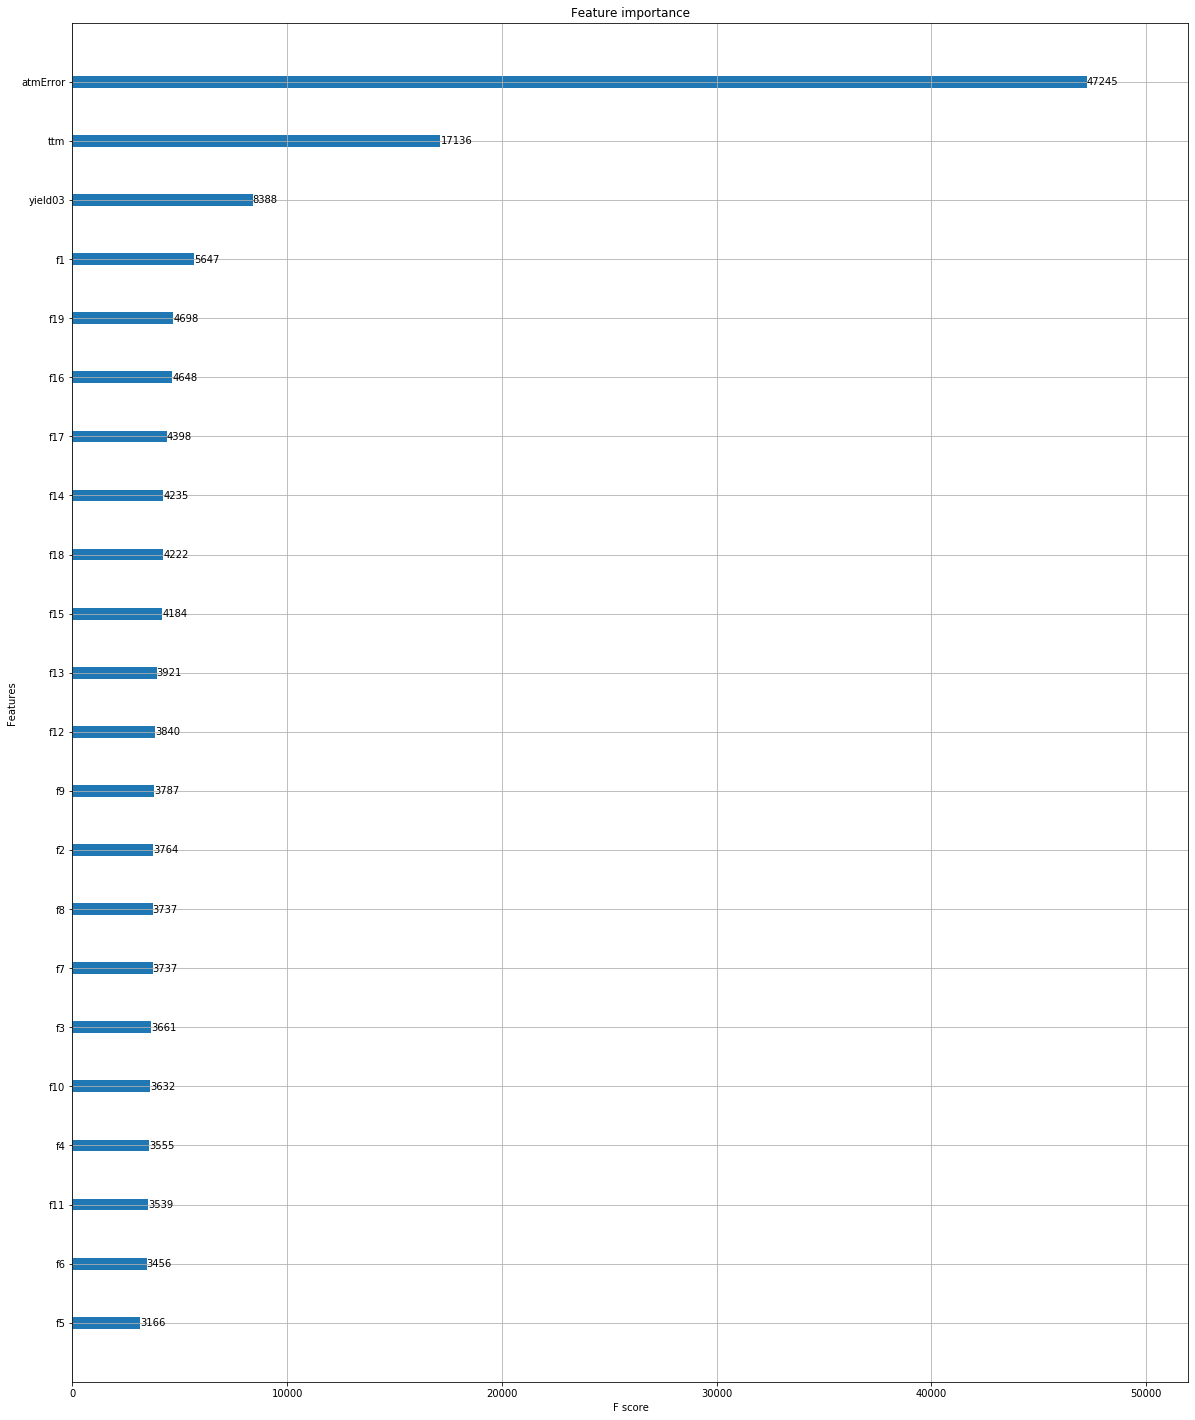

In [12]:
plt.rcParams['figure.figsize'] = [20, 25]
plot_importance(model)
plt.show()

# Testing BNF+NF on NF and BNF separately 

In [13]:
## NF


n_feats = Ntest.sample(frac=1).reset_index(drop=True)

nf_Ytest = n_feats.loc[:, 'Target']
nf_Xtest = n_feats.iloc[:, :-1]

featNames = list(nf_Xtest)

nf_Xtest = scaler.transform(nf_Xtest)
nf_Xtest = pd.DataFrame(nf_Xtest, columns = featNames)


pred = model.predict(nf_Xtest)

dist_sum = 0
for i in range(len(pred)):
    dist = abs(pred[i] - nf_Ytest[i])
    dist_sum = dist_sum + dist
    
print("NEM ::", (dist_sum*bin_width)/len(nf_Ytest))


NEM :: 0.17221605623381428


In [14]:
## BNF



b_feats = Btest.sample(frac=1).reset_index(drop=True)



bnf_Ytest = b_feats.loc[:, 'Target']
bnf_Xtest = b_feats.iloc[:, :-1]

featNames = list(bnf_Xtest)

bnf_Xtest = scaler.transform(bnf_Xtest)
bnf_Xtest = pd.DataFrame(bnf_Xtest, columns = featNames)


pred = model.predict(bnf_Xtest)

dist_sum = 0
for i in range(len(pred)):
    dist = abs(pred[i] - bnf_Ytest[i])
    dist_sum = dist_sum + dist
    
print("NEM ::", (dist_sum*bin_width)/len(bnf_Ytest))


NEM :: 0.19257898603967671


In [138]:
sbintest = sbintest.sample(frac =1).reset_index(drop=True)

sbin_Ytest = sbintest.loc[:, 'Target']
sbin_Xtest = sbintest.iloc[:, :-1]

featNames = list(sbin_Xtest)

sbin_Xtest = scaler.transform(sbin_Xtest)
sbin_Xtest = pd.DataFrame(sbin_Xtest, columns = featNames)



pred = model.predict(sbin_Xtest)

dist_sum = 0
for i in range(len(pred)):
    dist = abs(pred[i] - sbin_Ytest[i])
    dist_sum = dist_sum + dist
    
print("NEM ::", (dist_sum*bin_width)/len(sbin_Ytest))

NEM :: 0.3792553191489362


In [140]:
len(sbin_Xtest)

940